In [3]:
# switch to main dir to fix imports
import os

if os.getcwd().endswith("notebooks"):
    os.chdir("..")
    print("using project root as working dir")

using project root as working dir


In [4]:
from dataclasses import asdict
from datetime import datetime
import time
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import glob
import torch
from tqdm.notebook import tqdm
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import math

from src.evaluator import Evaluator
from src.args import Args
import src.graphs as graphs

In [5]:
# start autoreload
%load_ext autoreload
%autoreload 2

# select device
device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
print(f"using {device} device")

# global seaborn settings
sns.set_context("paper")
sns.set_style("darkgrid", {"grid.color": ".8"})
palette = "Dark2"

using cuda device


# Load data frames


In [7]:
# load data frame from folder
path = "./out/load"
files = glob.glob(os.path.join(path, "*.csv.zip"))
df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

# either replace or concat
result = df
#df_result = pd.concat((df_result, df), ignore_index=True)

In [12]:
# save data frame
result.to_csv(os.path.join(path, "./saved.csv.zip"), index=False, compression=dict(method='zip', archive_name=f"data.csv"))

# Test if the framework learns distance threshold for RGGs

In [6]:
args = Args(
    graph_type="rgg",
    graph_size=1000,
    subgraph_alg="rjs",
    subgraph_size=100,
    subgraph_alpha=0.15,
)

experiment_key = f"rgg-threshold--{datetime.now().strftime('%d-%m--%H-%M')}"

In [7]:
graph = graphs.gen_graph(args)
evaluator = Evaluator(
    graph=graph,
    args=args,
    writer_log_dir=f"runs/{experiment_key}--{args.__hash__()}",
    device=device
)
# train the model
evaluator.train(
    optimizer=torch.optim.Adam(evaluator.net.parameters(), lr=1e-3),
    pbar=True
)
# test the model
test_loss, test_ap, test_f1, test_threshold = evaluator.test(
    epoch=args.epochs
)

  0%|          | 0/250 [00:00<?, ?it/s]

In [8]:
radius = math.sqrt(args.rgg_avg_degree / ((args.graph_size - 1) * math.pi))
print(f"model performance: "
      f"\n- loss: {test_loss}"
      f"\n- f1: {test_f1}"
      f"\n- ap: {test_ap}"
      f"\n- th: {test_threshold}")

model performance: 
- loss: 0.011751246381029512
- f1: 0.9397379755973816
- ap: 0.9893830418586731
- th: 0.43540704250335693


# Plot distance threshold for original graph

In [58]:
import itertools

node_feature_pairs = itertools.combinations(list(graph.nodes(data="feature")), 2)
edges = [
    (math.dist(u_f, v_f), (u_f, v_f))
    for ((u, u_f), (v, v_f)) in node_feature_pairs
]

values, labels = zip(*[
    ([*u, *v], 1 if d <= radius else 0)
    for (d, (u, v)) in edges
])
ds_values = torch.FloatTensor(values).to(device)
ds_labels = torch.IntTensor(labels).to(device)
dataset = TensorDataset(ds_values, ds_labels)
dataloader = DataLoader(dataset, batch_size=10, shuffle=False)

In [59]:
# predict edges of known distances
_, preds = evaluator.score(dataloader)
df_edges = pd.DataFrame([
    {
        "dist": edges[i][0],
        "u": edges[i][1][0],
        "v": edges[i][1][1],
        "i": i,
        "pred": p
    }
    for i, p in enumerate(preds.cpu().numpy())
])

/tmp/ipykernel_50599/126550091.py:2: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  g = sns.relplot(


radius: 0.056447189008708765


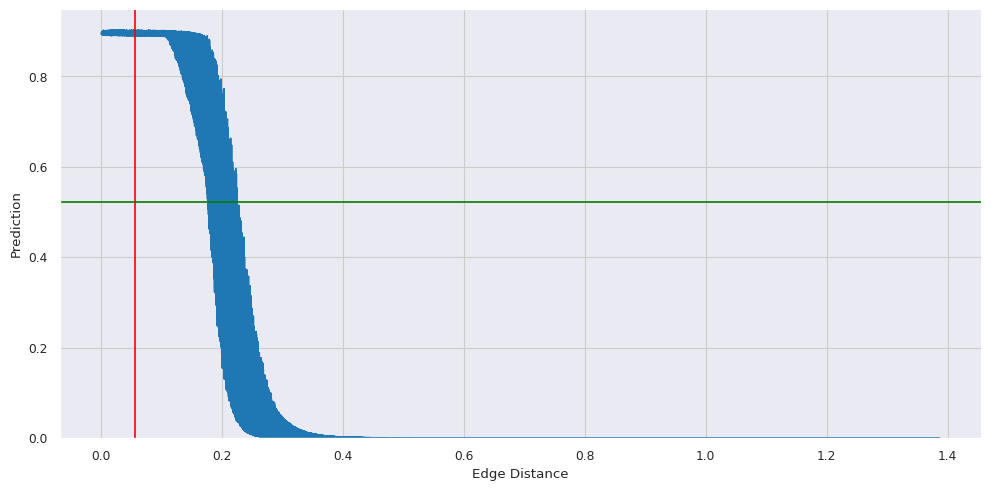

In [60]:
# plot results
g = sns.relplot(
    data=df_edges, kind="line",
    x="dist",
    y="pred",
    errorbar="sd",
    palette=palette,
    aspect=2,
)
g.set_axis_labels("Edge Distance", "Prediction")


print(f"radius: {radius}")
plt.axvline(x=radius, color="r")
plt.axhline(y=test_threshold, color="g")

plt.ylim(bottom=0)
plt.savefig('./out/original_edge_pred.pdf')

# Plot for test edges

In [9]:
# generate edges of known distances
radius = math.sqrt(args.rgg_avg_degree / ((args.graph_size - 1) * math.pi))
edges = [
    (d, graphs.gen_edge(d))
    for d in np.linspace(0.0, 1.0, num=10000)  # distances
    for _ in range(100)  # duplicates
]

values, labels = zip(*[
    ([*u, *v], 1 if d <= radius else 0)
    for (d, (u, v)) in edges
])
ds_values = torch.FloatTensor(values).to(device)
ds_labels = torch.IntTensor(labels).to(device)
dataset = TensorDataset(ds_values, ds_labels)
dataloader = DataLoader(dataset, batch_size=10, shuffle=False)

In [10]:
# predict edges of known distances
_, preds = evaluator.score(dataloader)
df_edges = pd.DataFrame([
    {
        "dist": edges[i][0],
        "u": edges[i][1][0],
        "v": edges[i][1][1],
        "i": i,
        "pred": p
    }
    for i, p in enumerate(preds.cpu().numpy())
])

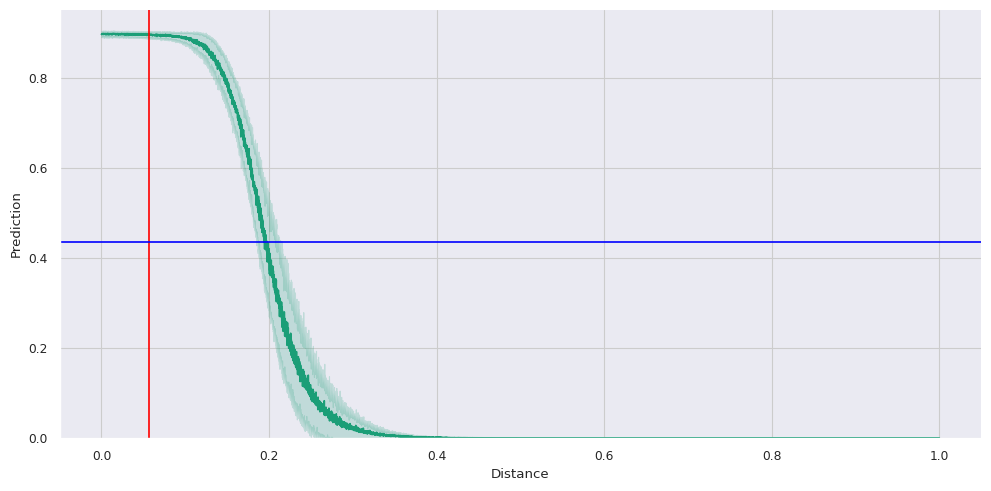

In [16]:
# plot results
df_edges["hue"] = 1  # trick to use color palett
g = sns.relplot(
    data=df_edges, kind="line",
    hue="hue",
    x="dist",
    y="pred",
    errorbar="sd",
    palette=palette,
    aspect=2,
    legend=False,
)
g.set_axis_labels("Distance", "Prediction")

plt.axvline(x=radius, color="r")
plt.axhline(y=test_threshold, color="b")

plt.ylim(bottom=0)
plt.savefig('./out/edge_pred.pdf')

In [15]:
print(radius)

0.056447189008708765
